# Activity 3.3 Bayesian Classifier
(last modified 31 Aug 2023)

### Learning Outcomes:

In this activity you learn how to:

- estimate mean and covariance parameters of a multi-variate normal distribution efficiently using `numpy`
- implement different variants of the Bayesian classifier with multi-variate normal distributions as class conditional distributions
- assess the appropriateness of different Bayesian classifier variants
- generate artifical input data for specific classes
- describe the advantages and disadvantages of the Bayesian classifier relative to logistic regression

Prequisites:

- Basics of `numpy`
- Bayesian Classifer (Lecture 6)

## Introduction: The Bayesian Classifier

Named somewhat misleadingly, the Bayesian classifier is not a Bayesian method in the sense of defining a prior distribution on its model parameters. Instead, it gets its name because its modelled conditional class probabilities are computed via Bayes rule,
\begin{equation*}
p(c_k | \boldsymbol{x}) = \frac{p(\boldsymbol{x} | c_k)p(c_k)}{\sum_{l =1}^K p(\boldsymbol{x} | c_l)p(c_l)} \enspace ,
\end{equation*}
where the $p(\boldsymbol{x} | c_k)$ and $p(c_k)$ are the explicitly modelled class conditional (input) distributions and the class priors, respectively.
Specifically, we are interested in variants of this approach where the class conditionals are modelled as **multivariate normal distributions**, i.e., as following the densities
\begin{equation*}
p(\boldsymbol{x} | c_k) = \frac{1}{\sqrt{(2\pi)^d |\Sigma_k|}} \exp\left(-\frac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu}_k)^T\Sigma^{-1}_k(\boldsymbol{x} - \boldsymbol{\mu}_k) \right) 
\end{equation*}
with the **mean vectors** $\boldsymbol{\mu}_k \in \R^p$ and the **covariance matrices** $\boldsymbol{\Sigma}_k \in \R^{p \times p}$ for each $k \in \{1, \dots, K\}$ being learnable parameters of the model. Here, the symbol $|\boldsymbol{A}|$ is used to denote the determinant of a matrix $\boldsymbol{A}$.

Let us illustrate this distribution with two example sets of parameters that will also form the ground truth of a synthetic data generator used later in this activity. Note that the density function can be imported from `scipy` as the method `pdf` from the class `scipy.stats.multivariate_normal`.

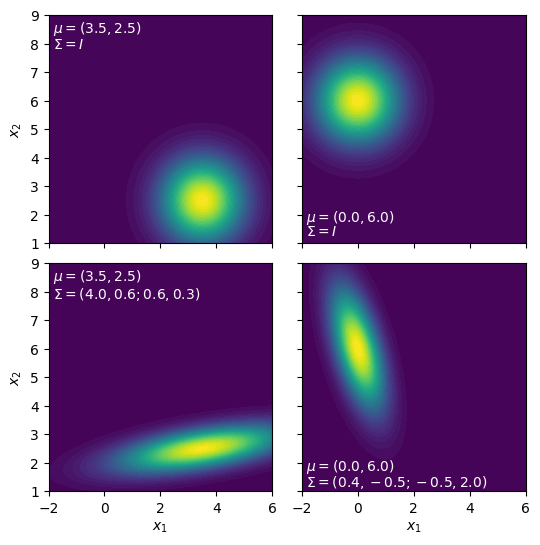

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

mu0 = np.array([3.5, 2.5])
mu1 = np.array([0.0, 6.0])
cov0 = np.array([[4, 0.6], [0.6, 0.3]])
cov1 = np.array([[0.4, -0.5], [-0.5, 2]])

_, axs = plt.subplots(2, 2, figsize=(5.5, 5.5), sharex=True, sharey=True, tight_layout=True)
xx1, xx2 = np.meshgrid(np.linspace(-2, 6, 100), np.linspace(1, 9, 100))
xx = np.column_stack((xx1.ravel(), xx2.ravel()))
pp1 = multivariate_normal.pdf(xx, mu0, np.eye(2)).reshape(100, 100)
pp2 = multivariate_normal.pdf(xx, mu1, np.eye(2)).reshape(100, 100)
pp3 = multivariate_normal.pdf(xx, mu0, cov0).reshape(100, 100)
pp4 = multivariate_normal.pdf(xx, mu1, cov1).reshape(100, 100)
axs[0, 0].contourf(xx1, xx2, pp1, levels=50) 
axs[0, 1].contourf(xx1, xx2, pp2, levels=50) 
axs[1, 0].contourf(xx1, xx2, pp3, levels=50) 
cp = axs[1, 1].contourf(xx1, xx2, pp4, levels=50)
axs[0, 0].text(0.02, 0.98, f'$\mu=({mu0[0]}, {mu0[1]})$', color='white', transform=axs[0, 0].transAxes, verticalalignment='top')
axs[0, 0].text(0.02, 0.90, f'$\Sigma=I$', color='white', transform=axs[0, 0].transAxes, verticalalignment='top')
axs[1, 0].text(0.02, 0.98, f'$\mu=({mu0[0]}, {mu0[1]})$', color='white', transform=axs[1, 0].transAxes, verticalalignment='top')
axs[1, 0].text(0.02, 0.90, f'$\Sigma=({cov0[0][0]}, {cov0[0][1]}; {cov0[1][0]}, {cov0[1][1]})$', color='white', transform=axs[1, 0].transAxes, verticalalignment='top')
axs[0, 1].text(0.02, 0.15, f'$\mu=({mu1[0]}, {mu1[1]})$', color='white', transform=axs[0, 1].transAxes, verticalalignment='top')
axs[0, 1].text(0.02, 0.08, f'$\Sigma=I$', color='white', transform=axs[0, 1].transAxes, verticalalignment='top')
axs[1, 1].text(0.02, 0.15, f'$\mu=({mu1[0]}, {mu1[1]})$', color='white', transform=axs[1, 1].transAxes, verticalalignment='top')
axs[1, 1].text(0.02, 0.08, f'$\Sigma=({cov1[0][0]}, {cov1[0][1]}; {cov1[1][0]}, {cov1[1][1]})$', color='white', transform=axs[1, 1].transAxes, verticalalignment='top')
axs[0, 0].set_ylabel('$x_2$')
axs[1, 0].set_ylabel('$x_2$')
axs[1, 0].set_xlabel('$x_1$')
axs[1, 1].set_xlabel('$x_1$')
plt.show()

Now are are going to generate a training dataset using the first set of covariance matrices (the simple unit case with spherical densities), which we will use as our first test case for the Bayes classifier variants.

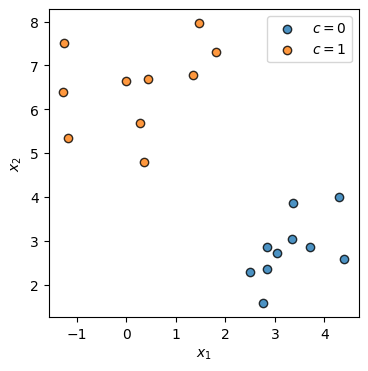

In [2]:
from activity3 import make_gaussian_mixture_data, scatter_data_by_target_value

p0 = 0.60; p1 = 1 - p0
class_probs = [p0, p1] 
mu = np.array([mu0, mu1])

n = 20
x_train, y_train = make_gaussian_mixture_data(n, mu, class_probs=class_probs, random_state=0)

plt.figure(figsize=(4, 4))
scatter_data_by_target_value(x_train, y_train)
plt.legend()
plt.show()

## MVN Parameter Estimation

To implement the Bayes classifier we need to be able to compute mean vectors and covariance matrices as well as class probabilities. For large datasets (and potentially many classes) it is important for computational efficiency to give vectorised implementations, i.e., those that avoid explicit loops over the data.


Let us start by exploring how we can efficiently estimate the class prior probabilities. At this point, it should be relatively easy for you to do this with a loop over the classes and then a numpy selection for each class. Another nice way which avoids explicitly looping over the classes is to use [`numpy.unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) with the option `return_counts=True`.

#### Task A: Estimate Class Prior Probabilities

**Estimate the class probabilities and store them in an array under the name `class_probs_hat`.**

In [3]:
classes, class_counts = np.unique(y_train, return_counts=True)
class_probs_hat = class_counts/len(y_train)

(class_probs - class_probs_hat)

array([ 0.1, -0.1])

Next, let us turn to the conditional means. We combine this exercise with a plotting function that allows us to show the estimated means relative to the true means. Again, at this point it should be quite straightforward for you to compute the mean of an array (using the `mean` method). Here, our task is only a little bit more complicated as we have to compute means for all input columns for all classes. Below we implement this only for two classes but it would be easy to extend this to more using a loop. 

#### Task B: Compute Data Mean per Class

**Finish the implementation of the plotting function below by computing the input mean vectors per class.**

Hints: Rememember how we
- used component-wise comparisons to generate Boolean arrays that are True for each index that corresponds to a data point of a specific class
- used fancy indexing to select a subset of an array based on a Boolean (or integer) array
- computed the vector of all column means of a matrix by calling the `mean` axis along the right axis (using the `axis` parameter)

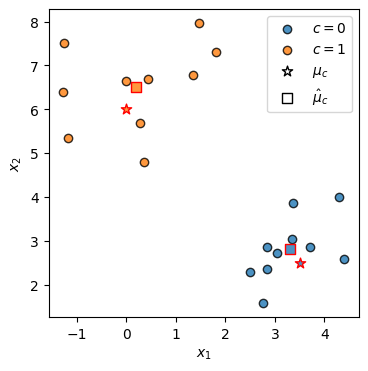

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from activity3 import make_gaussian_mixture_data, scatter_data_by_target_value

def scatter_data_with_means(x, y, mu):
    mu0_hat = x[y==0].mean(axis=0)
    mu1_hat = x[y==1].mean(axis=0)
    mu_hat = np.array([mu0_hat, mu1_hat])
    scs = scatter_data_by_target_value(x, y)
    for c in range(2):
        plt.scatter(mu_hat[c][0], mu_hat[c][1], fc=scs[c].get_facecolor(), marker='s', edgecolors='red', s=[60])
        plt.scatter(mu[c][0], mu[c][1], marker='*', fc=scs[c].get_facecolor(), edgecolors='red', s=[60])
    plt.scatter([], [], marker='*', fc='white', edgecolors='black', s=[60], label=r'$\mu_c$')
    plt.scatter([], [], marker='s', fc='white', edgecolors='black', s=[60], label=r'$\hat{\mu}_c$')

p0 = 0.60; p1 = 1 - p0
class_probs = [p0, p1] 
mu0 = np.array([3.5, 2.5])
mu1 = np.array([0.0, 6.0])
mu = np.array([mu0, mu1])

plt.figure(figsize=(4, 4))
scatter_data_with_means(x_train, y_train, mu)
plt.legend()
plt.show()

Turning to the (co-)variance estimation, it is again quite simple to estimate individual covariances via the definition of the maximum likelihood estimator
\begin{equation*}
\sigma^{(k)}_{ij} = \frac{1}{N_k} \sum_{n \in D_k} \left(x_{n,i}-\hat{\mu}^{(k)}_{n,i}\right)\left(x_{n,j}-\hat{\mu}^{(k)}_{n,j}\right)
\end{equation*}
as done in the next cell. Note that this definition yields the variances as special case for $i=j$.


In [5]:
a = x_train[y_train == 0]
((a[:, 0]-a[:, 0].mean())*(a[:, 1]-a[:, 1].mean())).mean()

0.23224605131304923

However, this method is not ideal because it would require us to explicitly loop over all combinations of input variables, which can in general be a large number. Instead we are looking for an implementation that is also vectorised in terms of $d$. Only for the variances (diagonal elements of the covariance matrix), this can be achieved via the `var` method of arrays as follows.

In [6]:
a.var(axis=0)

array([0.38035147, 0.46079863])

However, this does not help us for the variants where we have to estimate full covariance matrices. For that, we can use [`numpy.cov`](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) which estimates covariance matrices from data samples. The only two pitfalls here are that:

1. the function assumes per default that the data points are given as the columns of the input matrix (as opposed to our convention to store them as rows) and
2. that it computes not the maximum likelihood estimate but a slighlty modified version that corrects a finite sample bias of the MLE. 

Both can be changed via the options `rowvar=False` and `bias=True`, respectively.

#### Task C: Find Covariance Estimates 

**Use `numpy.cov` as described above to compute the MLE of the covariance matrix for class 0.**


In [7]:
cov_hat = np.cov(a, bias=True, rowvar=False)
cov_hat

array([[0.38035147, 0.23224605],
       [0.23224605, 0.46079863]])

## Implementing the Bayes Classifier

We are now ready to put everything together and implement the Bayes classifer. The implementation below stores during `fit`:

- the class priors in `self.class_priors_` as array with shape `(k,)`
- the conditional means in `self.cond_means_` as array with shape `(k, p)`
- the conditional covariance matrices in `self.cond_cov_` as array with shape `(k, p, p)`

The implementationa also correctly handles the case of a shared covariance matrix (option `shared_cov`) and whether to use full covariance matrices or Naive Bayes (`cond_ind`).

#### Task D: Implement `predict_proba`

**Finish the method code below by computing the conditional probabilities of all `m` test data points for each class and the vector of marginal probalities of all input data points (i.e., the denominator in Bayes rule).**

Hints: 

- After the loop, the array `cond_probs` should contain the conditional probabilities (densities) $p(x_i | c)$ in row $i$ and column $c$. Luckily, `scipy.multivariate_normal.pdf` can provide vectorised densities for an array of test points `x`.
- If the columns of `cond_probs` contain the probabilities of all test points for a given class, then computing the marginal probabilities $p(x)$ comes down to form an appropriate linear combination of those columns.

In [8]:
from scipy.stats import multivariate_normal

class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x, 
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

We cab now run the different variants and see how well they work.

#### Task E: Formulate your Expectations

Before looking at the results below, discuss your expectations by answering the following questions.

**Which of the four model variants do you expect to perform best on the example setting where both classes have unit covariances? Why? How many parameters are estimated by the different variants?**

*While all variants can learn the underlying distribution given sufficient data, all but the Naive Bayes variant with shared (co)-variances have unncessary parameters to learn, which is likely to cause additional error. Number of parameters:*
- *Naive Bayes (shared covariances): 4 for conditional means plus 2 for shared conditional variances*
- *Naive Bayes: 4 for conditional means plus 4 for conditional variances*
- *Bayes Classifier (shared covariances): 4 plus 3 for shared conditional covariances*
- *Bayes Classifier: 4 plus 6 for conditional covariances*

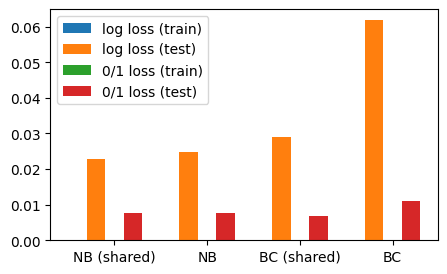

In [9]:
from sklearn.metrics import zero_one_loss, log_loss

def plot_model_performances(models, model_names, x_train, y_train, x_test, y_test):
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))

    xx = np.arange(len(models))
    bar_width = 1/(len(models)+1)
    group_width = len(models)*bar_width
    plt.bar(xx-group_width/2, train_log_losses, width=bar_width, label='log loss (train)')
    plt.bar(xx-group_width/2 + bar_width, test_log_losses, width=bar_width, label='log loss (test)')
    plt.bar(xx-group_width/2 + 2*bar_width, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx-group_width/2 +3*bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')
    plt.xticks(xx, model_names)

x_test, y_test = make_gaussian_mixture_data(10000, mu, class_probs=class_probs, random_state=1)

nb_shared = BayesianClassifier(shared_cov=True, cond_ind=True).fit(x_train, y_train)
nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)

models = [nb_shared, nb, bc_shared, bc]
model_names = ['NB (shared)', 'NB', 'BC (shared)', 'BC']

plt.subplots(1, 1, figsize=(5, 3))
plot_model_performances(models, model_names, x_train, y_train, x_test, y_test)
plt.legend()
plt.show()


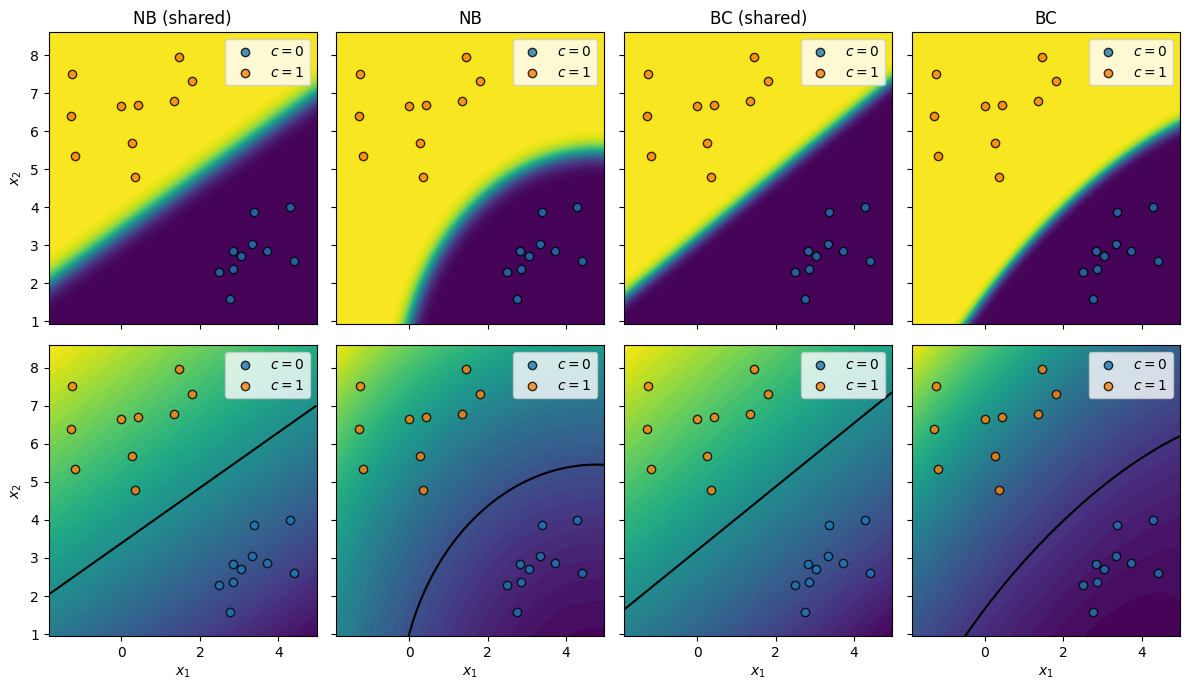

In [10]:
def plot_probs_and_log_odds(models, model_names, x, y, rel_margin=0.1):
    _ , axs = plt.subplots(2, len(models), figsize=(3*len(model_names), 7), sharex=True, sharey=True, tight_layout=True)
    
    a1, a2 = x.min(axis=0)
    b1, b2 = x.max(axis=0)
    x_margin = rel_margin*(b1-a1)
    y_margin = rel_margin*(b2-a2)

    xx1, xx2 = np.meshgrid(np.linspace(a1-x_margin, b1+x_margin, 100), np.linspace(a2-y_margin, b2+y_margin, 100))
    xx = np.column_stack((xx1.ravel(), xx2.ravel()))

    for i, model in enumerate(models):
        pp = model.predict_proba(xx)
        
        axs[0][i].contourf(xx1, xx2, pp[:, 1].reshape(100, 100), levels=50)
        scatter_data_by_target_value(x, y, ax=axs[0][i])
        axs[0][i].set_title(model_names[i])

        aa = model.decision_function(xx)
        axs[1][i].contourf(xx1, xx2, aa.reshape(100, 100), levels=50)
        axs[1][i].contour(xx1, xx2, aa.reshape(100, 100), levels=[0.0], colors='black')
        scatter_data_by_target_value(x, y, ax=axs[1][i])

        if i>0: 
            axs[0][i].set_ylabel(None)
            axs[1][i].set_ylabel(None)
        axs[0][i].set_xlabel(None)
        axs[0][i].set_xlim((a1-x_margin, b1+x_margin))
        axs[0][i].set_ylim((a2-y_margin, b2+y_margin))

plot_probs_and_log_odds(models, model_names, x_train, y_train)
plt.show()

## A More Complex Example

We now turn to the more complicated inputs with non-unit covariance matrices.

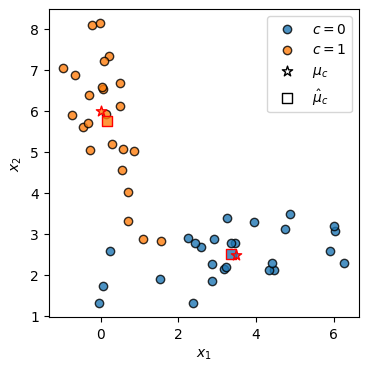

In [11]:
# cov1 = np.array([[4, 0.6], [0.6, 0.3]])
# cov2 = np.array([[0.4, -0.5], [-0.5, 2]])

n2 = 50
x2_train, y2_train = make_gaussian_mixture_data(n2, mu, covs=[cov0, cov1], class_probs=class_probs, random_state=0)

plt.figure(figsize=(4, 4))
scatter_data_with_means(x2_train, y2_train, mu)
plt.legend()
plt.show()

#### Task F: Formulate your Expectations

Before looking at the results below, again discuss your expectations.

**Which of the four model variants do you expect to perform best in the more complex setting? Why? How do you expect the variant with full but shared covariance to work?**

*Now the full covariance variant is the only version that can learn the underlying distribution. We recall from above that this involves 10 parameters, which for a training dataset of size 50 should already work reasonably well. The other variants are expected to work less well. Naive Bayes can only create spherical distributions which are clearly violated. The variant with shared full covariance should not work very well either because the two class specific covariances exactly average out to another spherical estimate when combined.*

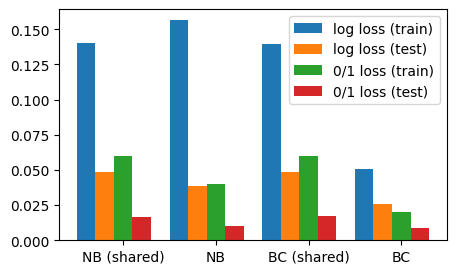

In [12]:
x2_test, y2_test = make_gaussian_mixture_data(10000, mu, covs=[cov0, cov1], class_probs=class_probs, random_state=1)
nbs2 = BayesianClassifier(shared_cov=True, cond_ind=True).fit(x2_train, y2_train)
nb2 = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x2_train, y2_train)
bcs2 = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x2_train, y2_train)
bc2 = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x2_train, y2_train)
models2 = [nbs2, nb2, bcs2, bc2]
model_names = ['NB (shared)', 'NB', 'BC (shared)', 'BC']

plt.subplots(1, 1, figsize=(5, 3))
plot_model_performances(models2, model_names, x2_train, y2_train, x2_test, y2_test)
plt.legend()
plt.show()

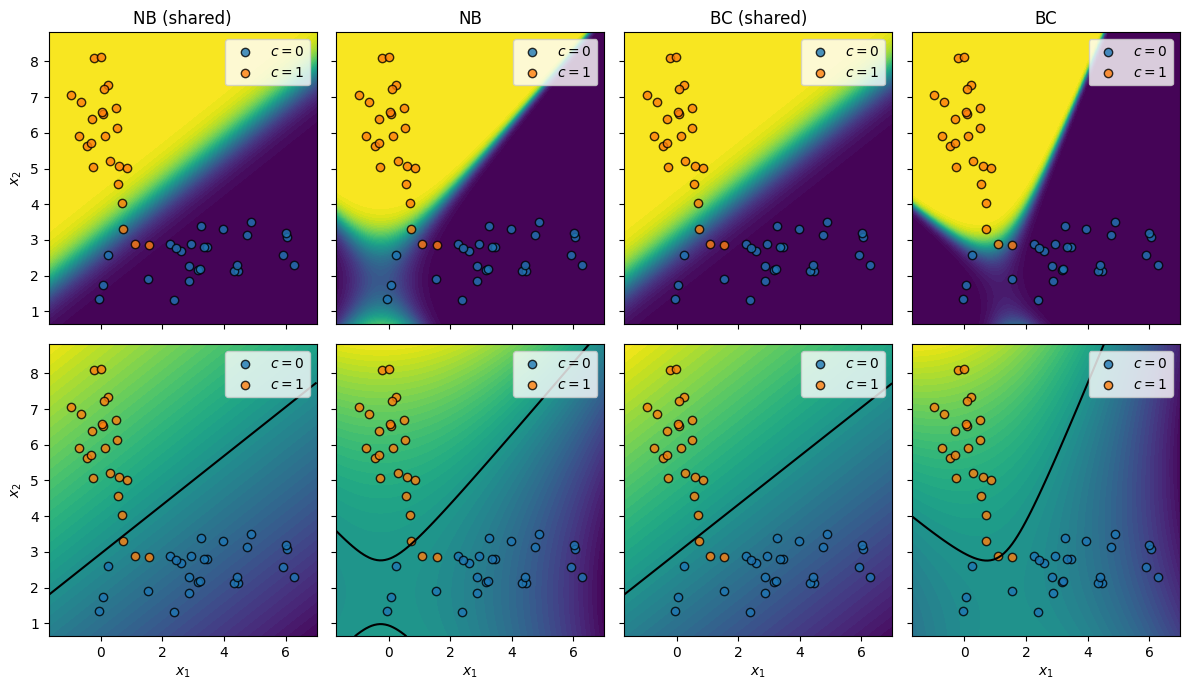

In [13]:
plot_probs_and_log_odds(models2, model_names, x2_train, y2_train)
plt.show()

## Generating Artificial Data

Finally, we can test the generative capabilities of the best performing model.

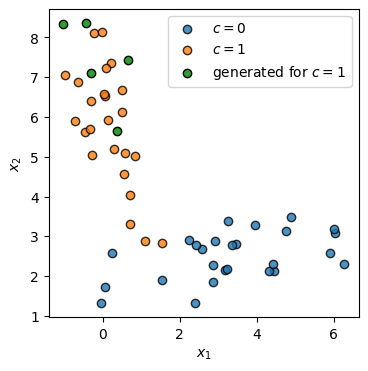

In [14]:
generated = bc2.generate(5, 1, 0)

plt.subplots(1, 1, figsize=(4, 4))
scatter_data_by_target_value(x2_train, y2_train)
plt.scatter(generated[:, 0], generated[:, 1], ec='black', label='generated for $c=1$')
plt.legend()
plt.show()

Of course the above is a toy example, but imagine if we learned a generative model for images of different classes of animals based on a large-scale image dataset. One can then generate new unseen images of the same classes of animals. 

Check [this](https://stablediffusionweb.com/) out to see examples from state-of-the-art text-to-image generative models. 

## Summary

#### Task: List the advantages and disadvantages of the Bayes classifier relative to logistic regression

Hint: For the disadvantages, think about how the number of parameters grows for high-dimensional input variables

*The Bayes Classifier is computationally very efficient as it can be learned simply by computing mean and covariance parameters in linear time (without potentially expensive iterative algorithms). It is also flexible, allowing for non-linear decision boundaries, and generative, allowing for the generation of synthetic data points for each class.*

*For higher dimensional data it might require many more data points than logistic regression to be effective. Even the Naive Bayes variant has four times as many parameters as logistic regression. The variants with non-zero off-diagonal elements even have a number of parameters that grows quadratically in the number of parameters of logistic regression.*
